In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import openmc

## StatePoint / Summary Files

#### Load the HDF5 Files

Let's begin by loading the statepoint HDF5 file for batch 100 into the Python API's `openmc.StatePoint` class:

In [2]:
sp = openmc.StatePoint('statepoint.100.h5')

We will do the same for the summary HDF5 file by loading into the `openmc.Summary` class:

In [3]:
su = openmc.Summary('summary.h5')

We can "link" the geometric and materials metadata in the summary to the tallies in the statepoint file with `StatePoint.link_with_summary(...)`:

In [4]:
sp.link_with_summary(su)

#### Inspect Simulation Metadata in `StatePoint`

First, we can inspect the date and time at which the simulation was run:

In [5]:
sp.date_and_time

'2016-04-28 11:11:37'

Similarly, we can inspect the current batch for our `StatePoint`:

In [6]:
sp.current_batch

100

Likewise, we can find a number of other simulation parameters in the `StatePoint`:
    
* `n_batches` - # of batches
* `n_inactive` - # of inactive batches
* `n_particles` - # of particles per batch
* `n_realizations` - # batches tallied to

In [7]:
print(sp.n_inactive, sp.n_batches, sp.n_particles, sp.n_realizations)

10 100 100000 90


OpenMC computes a number of estimators for the multiplication factor $k_{eff}$. Each of these estimators is stored as an attribute in the `StatePoint` class. We can report an ensemble-averaged estimator through the `StatePoint.k_combined` property with an `ndarray` storing the mean and uncertainty.

In [8]:
sp.k_combined

array([  1.02504491e+00,   2.71866786e-04])

Here we can see that our estimate $k_{eff}$ = {{np.round(sp.k_combined[0],5)}} $\pm$ {{np.round(sp.k_combined[1],5)}}

#### Extract Model Geometry and Materials from `Summary`

We next turn to consider the metadata stored in the `Summary` class. This class is used to store data that is *invariant* between batches - *e.g.*, the simulation geometric and materials models - rather than statistical estimators that vary by batch which are stored in the `StatePoint` files. First, we can find the entire OpenMC model built as a `Geometry` object in the `Summary.openmc_geometry` property:

In [9]:
su.openmc_geometry

In addition, the `Summary` includes properties to quickly and easily access the `Materials`, `Cells`, `Universes`, etc. directly. The following are included as properties in the `Summary`:

* `materials` - `dict` of `Material` objects indexed by ID
* `surfaces` - `dict` of `Surface` objects indexed by ID
* `cells` - `dict` of `Cell` objects indexed by ID
* `universes` - `dict` of `Universe` objects indexed by ID
* `lattices` - `dict` of `Lattice` objects indexed by ID

For example, let's inspect the `materials`:

In [10]:
su.materials

{1: Material
 	ID             =	10000
 	Name           =	1.6% fuel
 	Density        =	0.06901765345640536 [atom/b-cm]
 	S(a,b) Tables  
 	Nuclides       
 	U-235          =	0.000375087734912743 [ao]
 	U-238          =	0.022628483061090606 [ao]
 	O-16           =	0.046014082660402016 [ao]
 	Elements       , 2: Material
 	ID             =	10001
 	Name           =	borated water
 	Density        =	0.07427671201342415 [atom/b-cm]
 	S(a,b) Tables  
 	Nuclides       
 	H-1            =	0.049510130303184366 [ao]
 	O-16           =	0.024758568911546514 [ao]
 	B-10           =	8.012798693263813e-06 [ao]
 	Elements       , 3: Material
 	ID             =	10002
 	Name           =	zircaloy
 	Density        =	0.043874251943143476 [atom/b-cm]
 	S(a,b) Tables  
 	Nuclides       
 	Zr-90          =	0.043874251943143476 [ao]
 	Elements       }

For relatively large models, the number of `Materials`, `Cells`, `Universes`, etc. may be unwieldy to digest in such a format. However, if we give our objects names (or labels) then we can easily retrieve them directly from the `Geometry`. For example, let's retrieve the `Material` named `"Fuel"`:

In [11]:
fuel = su.openmc_geometry.get_materials_by_name('Fuel')
print(fuel)

[Material
	ID             =	10000
	Name           =	1.6% fuel
	Density        =	0.06901765345640536 [atom/b-cm]
	S(a,b) Tables  
	Nuclides       
	U-235          =	0.000375087734912743 [ao]
	U-238          =	0.022628483061090606 [ao]
	O-16           =	0.046014082660402016 [ao]
	Elements       
]


As we can see, the `get_materials_by_name(...)` method will return a `list` of all `Material` objects with the name `"Fuel"` - in  this case, there is only one such `Material`. Let's now retrieve the `Material` named `"Moderator"`, as well as the `Cell` objects named `"Fuel"` and `"Moderator"`:

In [12]:
# Extract moderator Material
moderator = su.openmc_geometry.get_materials_by_name('Moderator')

# Extract fuel and moderator Cells
fuel_cell = su.openmc_geometry.get_cells_by_name('Fuel')
moderator_cell = su.openmc_geometry.get_cells_by_name('Moderator')

We will return to use these `Material` and `Cell` objects later when we process some of our `Tallies`.

#### Access Fission Source Sites

The `StatePoint` contains all of the fission source sites for the corresponding batch in the `source` NumPy array. This array includes the following information about each source:

* Energy (`"E"`)
* Location (`"xyz"`)
* Direction (`"uvw"`)

Let's inspect the energies (in MeV) indexed by key `"E"`:

In [13]:
sp.source['E']

array([ 2.43590934,  2.18546231,  2.94830197, ...,  1.79776828,
        1.64140679,  2.23196842])

To make things more interesting, we can use NumPy and Matplotlib to plot a histogram of those energies in the `source` array.

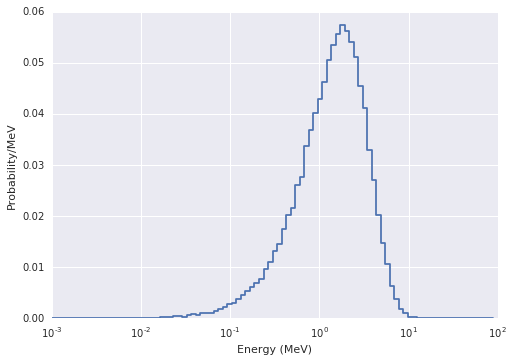

In [14]:
# Create log-spaced energy bins from 1 keV to 100 MeV
energy_bins = np.logspace(np.log10(1e-3), np.log10(1e2), 100)

# Calculate pdf for source energies
probability, bin_edges = np.histogram(sp.source['E'], energy_bins, density=True)

# Plot source energy PDF
plt.semilogx(energy_bins[:-1], probability*np.diff(energy_bins), linestyle='steps')
plt.xlabel('Energy (MeV)')
plt.ylabel('Probability/MeV')

## Tally Data Extraction

#### Extracting Tallies from a `StatePoint`

Our `StatePoint` also has a number of different `Tally` objects stored in the `StatePoint.tallies` as a `dict`. We can inspect one the `Tally` objects by directly indexing into `tallies` with the appropriate ID:

In [15]:
print(sp.tallies[10000])

Tally
	ID             =	10000
	Name           =	mesh fission
	Filters        =	
                		mesh	[10000]
	Nuclides       =	U-235 U-238 
	Scores         =	['fission']
	Estimator      =	tracklength



As we can see, the `Tally` with ID=10000 is called `"mesh fission"` and has a `"mesh"` `Filter`, a `"fission"` score and two `"U-235"` and `"U-238"` nuclide bins. In addition, the `Tally` was computed with a `"tracklength"` estimator.

Although it may be convenient to directly index into the `tallies` collection for problems with only a handful of `Tally` objects, this is not a robust or scalable approach for problems with many `Tally` objects. Instead, we recommend the use of the `StatePoint.get_tally(...)` method which allows one to retrieve a `Tally` object with an arbitrary subset or combination of the following information:

* integer ID
* string name
* one or more string scores
* one or more `Filter` objects
* one or more string nuclides

As an example, let's retrieve the `Tally` using its string name:

In [16]:
mesh_fiss = sp.get_tally(name='mesh fission')

As we can see, this has extracted the `Tally` with the name `"mesh_fiss"` into a new Python variable called `mesh_fiss`. Let's proceed to extract all of the `Tally` objects into their own respective variables.

In [17]:
flux = sp.get_tally(name='flux')
distribcell = sp.get_tally(name='distribcell')
therm_abs = sp.get_tally(name='thermal absorption')
tot_abs = sp.get_tally(name='total absorption')

#### Extracting Data from a `Tally`

The obvious first thing you may wish to do with a `Tally` object is to inspect the batch mean values in each bin. To start, let's inspect the type of the `Tally.mean` property to determine that it is a NumPy array:

In [18]:
print(type(mesh_fiss.mean))

<class 'numpy.ndarray'>


Next, let's use the `ndarray.shape` attribute to determine the number of dimensions are contained within our `mean` NumPy array:

In [19]:
print(mesh_fiss.mean.shape)

(289, 2, 1)


This result informs us that `mesh_fiss` has a 3D mean array with dimensions 289 $\times$ 2 $\times$ 1. In fact all `Tally` objects in OpenMC store a `mean` array using three dimensions corresponding to the following:

* `Filter` bins
* Nuclide bins
* Score bins

In our case, the first dimension with length 289 corresponds to 289 `Mesh` `Filter` bins for the 17 $\times$ 17 PWR assembly. The second dimension of length 2 corresponds to the `"U-235"` and `"U-238"` nuclide bins while the final dimension corresponds to our single `"fission"` score bin.

Now that we understand how data is stored and indexed, let's inspect the data for the first five `Mesh` `Filter` bins:

In [20]:
print(mesh_fiss.mean[:5,:,:])

[[[ 0.00137513]
  [ 0.00010392]]

 [[ 0.00138107]
  [ 0.00010412]]

 [[ 0.00139326]
  [ 0.00010331]]

 [[ 0.00140854]
  [ 0.00010364]]

 [[ 0.00141468]
  [ 0.00010343]]]


We can similarly inspect the standard deviation for our tally data which is stored in the `std_dev` array:

In [21]:
print(mesh_fiss.std_dev[:5,:,:])

[[[  6.37357413e-06]
  [  4.64062717e-07]]

 [[  6.34196163e-06]
  [  4.79317285e-07]]

 [[  6.00758458e-06]
  [  3.84259335e-07]]

 [[  5.79400110e-06]
  [  4.18209244e-07]]

 [[  6.87684034e-06]
  [  4.42451005e-07]]]


Of course since the data is stored in NumPy arrays, we can easily compute the percent relative error of each tally value simply by dividing the `std_dev` array by the `mean` array:

In [22]:
rel_err = mesh_fiss.std_dev / mesh_fiss.mean * 100.
print(rel_err[:5,:,:])

[[[ 0.46348767]
  [ 0.44654727]]

 [[ 0.45920763]
  [ 0.46035125]]

 [[ 0.43118966]
  [ 0.37196268]]

 [[ 0.41134734]
  [ 0.40352719]]

 [[ 0.48610613]
  [ 0.42776103]]]


Although we can directly access the `mean` and `std_dev` arrays in our `Tally` object, this is not a scalable or flexible approach for sophisticated simulation workflows. In many situations you may wish to extract a subset of the data from a `Tally` for some analysis. The `Tally.get_values(...)` method is an attractive alternative for these cases. 

Let's consider the extraction of data from our `mesh_fiss` `Tally` specifically for `"U-235"` into a new NumPy array variable called `u235_fission`:

In [23]:
u235_fission = mesh_fiss.get_values(nuclides=['U-235'])
print(u235_fission.shape)

(289, 1, 1)


As we can see, the `u235_fission` array has dimensions 289 $\times$ 1 $\times$ 1 as expected. 

## Plotting `Tally` Data

OpenMC's tight coupling with Python permits us to generate nice plots of our tally data directly from within the Jupyter Notebook.

#### Plotting Mesh Tallies

For our first example, we will use Matplotlib to plot the fission rate mesh tally in the `mesh_fiss` `Tally`. First, let's extract the `"U-235"` fission rate mean and relative error arrays into their own respective variables:

In [24]:
mean = mesh_fiss.get_values(nuclides=['U-235'], value='mean')
rel_err = mesh_fiss.get_values(nuclides=['U-235'], value='rel_err')

We will use Matplotlib to plot 2D heatmaps of arrays. In order to do so, we must first reshape our arrays to be 2D corresponding to the 17 $\times$ 17 `Mesh`:

In [25]:
# Reshape the arrays
mean.shape = (17, 17)
rel_err.shape = (17, 17)

Now we can use Matplotlib's `imshow` method to display our data side-by-side:

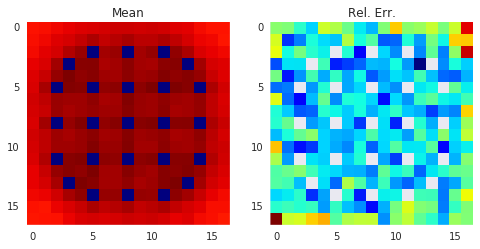

In [26]:
# Plot OpenMC's fission rates in the left subplot
fig = plt.subplot(121)
plt.imshow(mean, interpolation='none', cmap='jet')
plt.title('Mean')
plt.grid(False)

# Plot OpenMOC's fission rates in the right subplot
fig2 = plt.subplot(122)
plt.imshow(rel_err, interpolation='none', cmap='jet')
plt.title('Rel. Err.')
plt.grid(False)

This mesh tally of fission rates particularly informative since the dark blue guide tube do not have any fission and skew the color bar. We can rectify this issue with a little trick to Matplotlib's color scheme as follows.

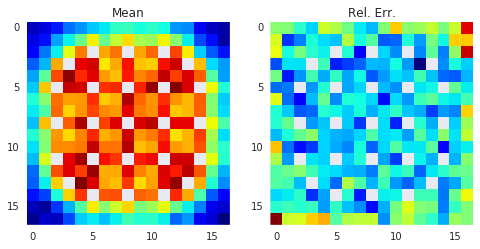

In [27]:
# Assign a NaN to zero fission rates in guide tubes
# Matplotlib will ignore "bad" values in the colorbar
mean[mean == 0.] = np.nan
cmap = plt.get_cmap('jet')
cmap.set_bad(alpha=0.)

# Plot fission rates in the left subplot
fig = plt.subplot(121)
plt.imshow(mean, interpolation='none', cmap=cmap)
plt.title('Mean')
plt.grid(False)

# Plot relative errors in the right subplot
fig2 = plt.subplot(122)
plt.imshow(rel_err, interpolation='none', cmap='jet')
plt.title('Rel. Err.')
plt.grid(False)

## Plotting Flux Tallies

For our second example we will plot the neutron flux in energy across the fuel assembly. The neutron flux is encapsulated by the `flux` `Tally` that we extracted from the `StatePoint`. First, let's extract the mean values into an NumPy array variable called `fluxes`:

In [28]:
# Extract the flux mean values array
fluxes = flux.mean.flatten()

# Extend the flux array for Matplotlib's step plot
fluxes = np.insert(fluxes, 0, fluxes[0])

Next we will extract the energies for each tally bin by retrieving the "energy" `Filter` using the `Tally.find_filter(...)` method:

In [29]:
# Extract the "energy" Filter from the Tally
energy_filter = flux.find_filter('energy')
energies = energy_filter.bins

Finally, we can plot the flux data in a log-log plot with Matplotlib:

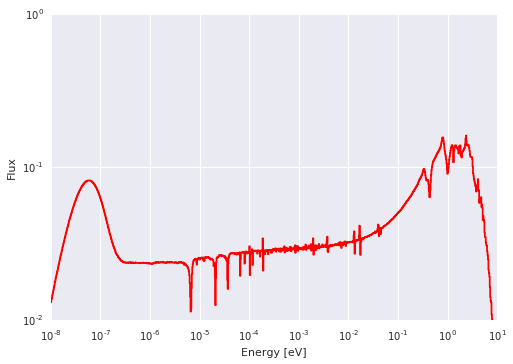

In [30]:
fig = plt.figure()
plt.loglog(energies, fluxes, drawstyle='steps', c='r')
plt.xlabel('Energy [eV]')
plt.ylabel('Flux')

The plot exhibits high and low energy peaks as well as degradation in the resonance region just as we expect for an LWR.

## Pandas DataFrames

The preceding section highlighted how to directly extract raw data from a `Tally` object as NumPy arrays. One primary difficulty that may arise with tally data processing is that the data in a simple NumPy array is *opaque* - *i.e.*, it is not clear which data points correspond to which `Filter`, nuclide or score bins. This section illustrates a powerful of OpenMC's Python API which leverages the [Pandas](http://pandas.pydata.org/) data analysis library. The Pandas package is rich and extensive. In this section we will focus on the use of Pandas `DataFrame` objects to encapsulate tally data.

#### Get a Pandas `DataFrame` of `Tally` Data

A Pandas DataFrame may be retrieved from any OpenMC `Tally` object through the `Tally.get_pandas_dataframe(...)` method. Let's give it a try and build a `DataFrame` in a variable called `df` for our `Tally` called `mesh_fiss`:

In [31]:
df = mesh_fiss.get_pandas_dataframe()

We can easily inspect a Pandas DataFrame in the Jupyter Notebook by simply ending a cell with the variable holding a `DataFrame`. Due to the size of the dataset in our `mesh_fiss` `Tally` we will use the `DataFrame.head(...)` method to restrict the output to only the first 10 rows on the `DataFrame`:

In [32]:
df.head(10)

mesh 10000       nuclide    score      mean     std. dev.
           x  y  z                                         
0          1  1  1   U-235  fission  0.001375  6.373574e-06
1          1  1  1   U-238  fission  0.000104  4.640627e-07
2          1  2  1   U-235  fission  0.001381  6.341962e-06
3          1  2  1   U-238  fission  0.000104  4.793173e-07
4          1  3  1   U-235  fission  0.001393  6.007585e-06
5          1  3  1   U-238  fission  0.000103  3.842593e-07
6          1  4  1   U-235  fission  0.001409  5.794001e-06
7          1  4  1   U-238  fission  0.000104  4.182092e-07
8          1  5  1   U-235  fission  0.001415  6.876840e-06
9          1  5  1   U-238  fission  0.000103  4.424510e-07

As we can see, the Pandas `DataFrame` presents the data in a human-friendly format with the filter, nuclide and score information along with the estimated means and standard deviations. Let's inspect the Pandas DataFrame the same for the `flux` `Tally`:

In [33]:
df = flux.get_pandas_dataframe()
df.head(10)

,energy low [MeV],energy high [MeV],nuclide,score,mean,std. dev.
0,1.000000e-08,1.020733e-08,total,flux,0.013111,0.000040
1,1.020733e-08,1.041895e-08,total,flux,0.013644,0.000048
2,1.041895e-08,1.063496e-08,total,flux,0.014035,0.000046
3,1.063496e-08,1.085545e-08,total,flux,0.014539,0.000052
4,1.085545e-08,1.108052e-08,total,flux,0.014996,0.000045
5,1.108052e-08,1.131024e-08,total,flux,0.015503,0.000057
6,1.131024e-08,1.154474e-08,total,flux,0.015992,0.000045
7,1.154474e-08,1.178409e-08,total,flux,0.016522,0.000052
8,1.178409e-08,1.202840e-08,total,flux,0.017075,0.000058
9,1.202840e-08,1.227778e-08,total,flux,0.017799,0.000054


The Pandas DataFrames feature supports all possible combinations of `Filters`, nuclides and scores which may be composed into a `Tally` objects. As a final example, let's consider the `distribcell` `Tally` which uses a "distribcell" `Filter`:

In [34]:
df = distribcell.get_pandas_dataframe()
df.head(10)

,distribcell,nuclide,score,mean,std. dev.
0,0,U-235,absorption,0.001652,7.491498e-06
1,0,U-235,fission,0.001375,6.373574e-06
2,0,U-238,absorption,0.001150,7.490925e-06
3,0,U-238,fission,0.000104,4.640627e-07
4,1,U-235,absorption,0.001658,7.474689e-06
5,1,U-235,fission,0.001381,6.341962e-06
6,1,U-238,absorption,0.001153,7.287815e-06
7,1,U-238,fission,0.000104,4.793173e-07
8,2,U-235,absorption,0.001673,7.097183e-06
9,2,U-235,fission,0.001393,6.007585e-06


It can often be useful to visualize the specific location for each "distribcell" `Filter` bin. The `Tally.get_pandas_dataframe(...)` method supports an optional parameter for the `Summary` object specifically for this purpose:

In [35]:
df = distribcell.get_pandas_dataframe(summary=su)
df.head(10)

level 1      level 2           level 3        distribcell nuclide  \
     cell univ     lat              cell   univ                       
       id   id      id  x   y  z      id     id                       
0   10006    0   10002  0  16  0   10000  10000           0   U-235   
1   10006    0   10002  0  16  0   10000  10000           0   U-235   
2   10006    0   10002  0  16  0   10000  10000           0   U-238   
3   10006    0   10002  0  16  0   10000  10000           0   U-238   
4   10006    0   10002  0  15  0   10000  10000           1   U-235   
5   10006    0   10002  0  15  0   10000  10000           1   U-235   
6   10006    0   10002  0  15  0   10000  10000           1   U-238   
7   10006    0   10002  0  15  0   10000  10000           1   U-238   
8   10006    0   10002  0  14  0   10000  10000           2   U-235   
9   10006    0   10002  0  14  0   10000  10000           2   U-235   

        score      mean     std. dev.  
                                       
                                       
0  absorption  0.001652  7.491498e-06  
1     fission  0.001375  6.373574e-06  
2  absorption  0.001150  7.490925e-06  
3     fission  0.000104  4.640627e-07  
4  absorption  0.001658  7.474689e-06  
5     fission  0.001381  6.341962e-06  
6  absorption  0.001153  7.287815e-06  
7     fission  0.000104  4.793173e-07  
8  absorption  0.001673  7.097183e-06  
9     fission  0.001393  6.007585e-06

#### Pandas Fancy Indexing

Although Pandas DataFrames present complex tally data in a visually-appealing tabular format, the real power of Pandas is through its rich feature set for data munging and modeling. Unfortunately, we don't have time in this workshop to even scratch the surface of what is possible with Pandas, but we will highlight one nice feature in fancy indexing here.

First, Pandas supports fance indexing schemes to permit easy selection of subsets of data from a `DataFrame`. For example, consider the case where we may wish to create a `DataFrame` in a variable called `sub_df` with only the "U-235" tally data in the `mesh_fiss` `Tally:

In [36]:
df = mesh_fiss.get_pandas_dataframe()
sub_df = df[df['nuclide'] == 'U-235']
sub_df.head(5)

mesh 10000       nuclide    score      mean std. dev.
           x  y  z                                     
0          1  1  1   U-235  fission  0.001375  0.000006
2          1  2  1   U-235  fission  0.001381  0.000006
4          1  3  1   U-235  fission  0.001393  0.000006
6          1  4  1   U-235  fission  0.001409  0.000006
8          1  5  1   U-235  fission  0.001415  0.000007

Now consider the case where we wish to select from `sub_df` those mesh cells which have a "fission" rate that is above the average:

In [37]:
# Replace 0's with NaN to eliminate them from average
sub_df = sub_df.replace(0, np.nan)

# Extract rows corresponding to above average fission rates
indices = sub_df['mean'] > sub_df['mean'].mean()
above_avg = sub_df[indices]
above_avg.head(5)

mesh 10000        nuclide    score      mean std. dev.
            x   y  z                                     
44          2   6  1   U-235  fission  0.001484  0.000006
50          2   9  1   U-235  fission  0.001488  0.000007
56          2  12  1   U-235  fission  0.001484  0.000006
74          3   4  1   U-235  fission  0.001480  0.000006
76          3   5  1   U-235  fission  0.001508  0.000006

Finally, let's use Pandas fancy indexing to select the data corresponding to those mesh cells in the lower left triangle of the mesh:

In [38]:
indices = df[('mesh 10000', 'x')] > df[('mesh 10000', 'y')]
lower = df[indices]
lower.head(5)

mesh 10000       nuclide    score      mean     std. dev.
            x  y  z                                         
34          2  1  1   U-235  fission  0.001382  6.761401e-06
35          2  1  1   U-238  fission  0.000104  3.678533e-07
68          3  1  1   U-235  fission  0.001386  6.879279e-06
69          3  1  1   U-238  fission  0.000104  3.748289e-07
70          3  2  1   U-235  fission  0.001410  5.960832e-06

## Tally Manipulations

The OpenMC Python API supports a rich variety of methods to manipulate and combine `Tally` objects. The following sections briefly illustrate how to "slicing" and "summing" of `Tally` objects, as well as "`Tally` arithmetic" operations.

#### Tally Slicing

In some cases a `Tally` may have data for multiple `Filter` bins, nuclides or scores which must be treated separately in a downstream data processing workflow. The `Tally.get_slice(...)` method is custom designed to "slice" apart `Tally` objects into multiple "sub"-`Tally` objects by `Filter` bin(s), nuclide(s) and/or score(s).

As an example, let's consider our `distribcell` `Tally` object which has two scores ("absorption" and "fission") and two nuclides ("U-235" and "U-238"). First, we will slice `distribcell` into two new `Tally` objects for each score in the new variables `fission` and `absorption`:

In [39]:
# FIXME: Need to show sliced tally (print)
fission = distribcell.get_slice(scores=['fission'])
absorption = distribcell.get_slice(scores=['absorption'])
print(fission)
print(absorption)

Tally
	ID             =	10000
	Name           =	distribcell
	Filters        =	
                		distribcell	[10000]
	Nuclides       =	U-235 U-238 
	Scores         =	['fission']
	Estimator      =	tracklength

Tally
	ID             =	10001
	Name           =	distribcell
	Filters        =	
                		distribcell	[10000]
	Nuclides       =	U-235 U-238 
	Scores         =	['absorption']
	Estimator      =	tracklength



Similarly, we can slice apart the `Tally` objects in `fission` and `absorption` by nuclide:

In [40]:
u235_fission = fission.get_slice(nuclides=['U-235'])
u238_absorption = absorption.get_slice(nuclides=['U-238'])
print(u235_fission)
print(u238_absorption)

Tally
	ID             =	10002
	Name           =	distribcell
	Filters        =	
                		distribcell	[10000]
	Nuclides       =	U-235 
	Scores         =	['fission']
	Estimator      =	tracklength

Tally
	ID             =	10003
	Name           =	distribcell
	Filters        =	
                		distribcell	[10000]
	Nuclides       =	U-238 
	Scores         =	['absorption']
	Estimator      =	tracklength



As we have shown, `Tally` "slicing" returns a new `Tally` object which encapsulates only the data of interest. The original `Tally` remains intact and the new "sliced" `Tally` object supports the complete `Tally` API as does the original `Tally`. These two examples simply illustrate the basic concept of `Tally` "slicing" - `Tally.get_slice(...)` method supports arbitrary slicing over `Filter` bins and/or nuclides and/or scores simultaneously.

#### Tally Summation

In some scenarios it may be useful to perform a summation across `Filter` bins, nuclides or scores within a single `Tally`. The `Tally.summation(...)` method is custom built for such purposes. Similar to the `Tally` "slicing," `Tally` "summation" returns a new `Tally` object which encapsulates the summation of the underlying data.

As an example, let's compute the sum across nuclides "U-235" and "U-238" in our `distribcell` `Tally` object:

In [41]:
# Sum across nuclides
u235_plus_u238 = distribcell.summation(nuclides=['U-235', 'U-238'])
print(u235_plus_u238)

Tally
	ID             =	10004
	Name           =	
	Filters        =	
                		distribcell	[10000]
	Nuclides       =	sum(U-235, U-238) 
	Scores         =	['absorption', 'fission']
	Estimator      =	tracklength



The new `Tally` "sum" object in `u235_plus_u238` includes all of the same properties and methods as the original `distribcell` `Tally` object from which it came. As an example, we can report the first ten rows of the Pandas DataFrame for this `Tally` "sum":

In [42]:
df = u235_plus_u238.get_pandas_dataframe()
df.head(10)

,distribcell,sum(nuclide),score,mean,std. dev.
0,0,"(U-235, U-238)",absorption,0.002801,0.000011
1,0,"(U-235, U-238)",fission,0.001479,0.000006
2,1,"(U-235, U-238)",absorption,0.002811,0.000010
3,1,"(U-235, U-238)",fission,0.001485,0.000006
4,2,"(U-235, U-238)",absorption,0.002829,0.000010
5,2,"(U-235, U-238)",fission,0.001497,0.000006
6,3,"(U-235, U-238)",absorption,0.002844,0.000010
7,3,"(U-235, U-238)",fission,0.001512,0.000006
8,4,"(U-235, U-238)",absorption,0.002853,0.000011
9,4,"(U-235, U-238)",fission,0.001518,0.000007


As we can see from the `DataFrame`, `Tally.summation(...)` propagates the uncertainties through the summation. Note that the standard deviation is a biased estimate since `Tally.summation(...)` only uses a first order estimate of the uncertainty of the sum of random variables.

As we have shown, `Tally` "summation" returns a new `Tally` object which encapsulates a sum over the data of interest. The original `Tally` remains intact and the new `Tally` "sum" object supports the complete `Tally` API as does the original `Tally`. These two examples simply illustrate the basic concept of `Tally` "summation" - `Tally.summation(...)` method supports arbitrary summing over `Filter` bins and/or nuclides and/or scores simultaneously.

#### Tally Arithmetic

In many data workflows, one may arithmetically combine multiple tallies. This can be labor intensive and prone to errors, especially if the uncertainties must be propagated through the calculation. In many cases, users develop a data processsing apparatus "hard coded" for their particular use case. To mitigate this hassle for our users, we have developed a general toolbox of data processing features collectively collectively as "`Tally` arithmetic".

The OpenMC Python API allows multiple `Tally` objects to be direcly combined with each other using the basic binary operators for addition("+"), subtraction ("-"), multiplication ("\*") and division ("/"). In each case, the arithmetic operation is "broacast" across all `Filter` bins, nuclides and score bins in each of the `Tally` operands through a fast, vectorized NumPy array operation.

As an example, we can divide the `therm_abs` and `tot_abs` variables to compute the resonance escape probability which is defined as: $$p=\frac{\langle\Sigma_a\phi\rangle_T}{\langle\Sigma_a\phi\rangle}$$ where the subscript $T$ means thermal energies.

In [43]:
res_esc = therm_abs / tot_abs
res_esc.get_pandas_dataframe()

,energy low [MeV],energy high [MeV],nuclide,score,mean,std. dev.
0,0.0,6.250000e-07,total,absorption,0.721245,0.000403


Based on this analysis, our PWR fuel assembly has a resonance escape probability of ~72%. `Tally` "arithmetic" returns a new `Tally` object which encapsulates the operation over the data from the two `Tally` operands. The original `Tally` operands remain intact and the new resultant `Tally` object supports the complete `Tally` API as did the original `Tally` operands. As was the case for `Tally` summation, `Tally` arithmetic propagates the uncertainties through the calculation such that we have a mean and a standard deviation for the combined `Tally` object.

As a second example, let's consider a situation where we want to leverage `Tally` arithmetic's vectorized data processing framework. We will compute the dividend between the U-235 fission and U-235 absorption from our `distribcell` `Tally` which we sliced into `u235_fission` and `u238_absorption`:

In [44]:
fiss_over_abs = u235_fission / u238_absorption
df = fiss_over_abs.get_pandas_dataframe()
df.head(10)

,distribcell,nuclide,score,mean,std. dev.
0,0,(U-235 / U-238),(fission / absorption),1.196039,0.009563
1,1,(U-235 / U-238),(fission / absorption),1.197647,0.009356
2,2,(U-235 / U-238),(fission / absorption),1.205370,0.009320
3,3,(U-235 / U-238),(fission / absorption),1.221924,0.008785
4,4,(U-235 / U-238),(fission / absorption),1.223697,0.009550
5,5,(U-235 / U-238),(fission / absorption),1.225163,0.009648
6,6,(U-235 / U-238),(fission / absorption),1.232854,0.009465
7,7,(U-235 / U-238),(fission / absorption),1.235443,0.009288
8,8,(U-235 / U-238),(fission / absorption),1.238022,0.009046
9,9,(U-235 / U-238),(fission / absorption),1.233711,0.008467


We can easily view the distribution of the mean values in the Pandas `DataFrame` using the handy `plot(...)` method:

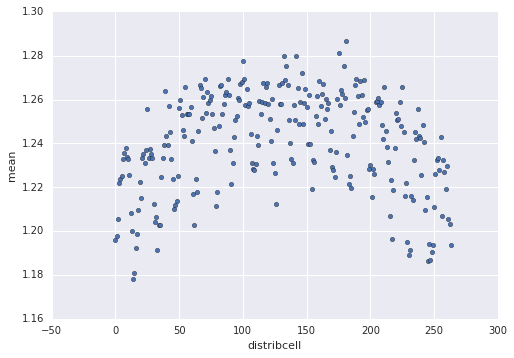

In [45]:
df.plot(kind='scatter', x='distribcell', y='mean')

As one might expect, there is a clear trend in the data indicative of the different spatial self-shielding effects for those pins in the center of the assembly adjacent to control rod guide tubes in contrast to those pins near the outer boundaries of the assembly.

One common application of `Tally` arithmetic is the calculation of multi-group cross sections (MGXS) which we will explore in the final two examples. Our `StatePoint` includes `Tally` objects necessary to compute a total MGXS - in particular, we need estimates of the total reaction rate as well as the flux to compute the total MGXS. In the following cell we extract two `Tally` objects, each with the name `"total mgxs"` but with `"total"` and `"flux"` scores:

In [46]:
total = sp.get_tally(name='total mgxs', scores=['total'])
flux = sp.get_tally(name='total mgxs', scores=['flux'])
print(total, flux)

Tally
	ID             =	10006
	Name           =	total mgxs
	Filters        =	
                		cell	[10000]
                		energy	[  0.00000000e+00   5.80000000e-08   1.40000000e-07   2.80000000e-07
   6.25000000e-07   4.00000000e-06   5.53000000e-03   8.21000000e-01
   2.00000000e+01]
	Nuclides       =	total 
	Scores         =	['total']
	Estimator      =	tracklength
 Tally
	ID             =	10005
	Name           =	total mgxs
	Filters        =	
                		cell	[10000]
                		energy	[  0.00000000e+00   5.80000000e-08   1.40000000e-07   2.80000000e-07
   6.25000000e-07   4.00000000e-06   5.53000000e-03   8.21000000e-01
   2.00000000e+01]
	Nuclides       =	total 
	Scores         =	['flux']
	Estimator      =	tracklength



As we can see, these `Tally` objects are for the `Cell` with ID=10000 (the fuel) and have an `"energy"` `Filter` with 8 energy groups. We can use `Tally` arithmetic to divide the total reaction rate by the flux to compute the 8-group total MGXS for the fuel assembly's fuel pins:

In [47]:
total_mgxs = total / flux
total_mgxs.get_pandas_dataframe()

,cell,energy low [MeV],energy high [MeV],nuclide,score,mean,std. dev.
0,10000,0.000000e+00,5.800000e-08,total,(total / flux),0.720452,0.000549
1,10000,5.800000e-08,1.400000e-07,total,(total / flux),0.550867,0.000492
2,10000,1.400000e-07,2.800000e-07,total,(total / flux),0.499248,0.000616
3,10000,2.800000e-07,6.250000e-07,total,(total / flux),0.460086,0.000494
4,10000,6.250000e-07,4.000000e-06,total,(total / flux),0.413687,0.000346
5,10000,4.000000e-06,5.530000e-03,total,(total / flux),0.552269,0.000238
6,10000,5.530000e-03,8.210000e-01,total,(total / flux),0.430398,0.000162
7,10000,8.210000e-01,2.000000e+01,total,(total / flux),0.274478,0.000143


Here we have an 8-group total MGXS computed across all of the fuel pins in the fuel assembly with the propagated uncertainties in each group.

Let's conclude by using `Tally` arithmetic to compute an 8-group scattering matrix. As before, we will extract two `Tally` objects, each with the name `"scatter matrix"` but with `"scatter"` and `"flux"` scores:

In [48]:
scatter = sp.get_tally(name='scatter matrix', scores=['scatter'])
flux = sp.get_tally(name='scatter matrix', scores=['flux'])
print(scatter)
print(flux)

Tally
	ID             =	10008
	Name           =	scatter matrix
	Filters        =	
                		cell	[10005]
                		energy	[  0.00000000e+00   5.80000000e-08   1.40000000e-07   2.80000000e-07
   6.25000000e-07   4.00000000e-06   5.53000000e-03   8.21000000e-01
   2.00000000e+01]
                		energyout	[  0.00000000e+00   5.80000000e-08   1.40000000e-07   2.80000000e-07
   6.25000000e-07   4.00000000e-06   5.53000000e-03   8.21000000e-01
   2.00000000e+01]
	Nuclides       =	H-1 O-16 B-10 
	Scores         =	['scatter']
	Estimator      =	analog

Tally
	ID             =	10007
	Name           =	scatter matrix
	Filters        =	
                		cell	[10005]
                		energy	[  0.00000000e+00   5.80000000e-08   1.40000000e-07   2.80000000e-07
   6.25000000e-07   4.00000000e-06   5.53000000e-03   8.21000000e-01
   2.00000000e+01]
	Nuclides       =	total 
	Scores         =	['flux']
	Estimator      =	analog



As we can see, these `Tally` objects are for the `Cell` with ID=10003 (the moderator) and have an `"energy"` `Filter` with 8 energy groups. In addition, the `scatter` `Tally` has an `"energyout"` `Filter` with 8 energy groups, and includes the reaction rates for all nuclides in the moderator.

We can use `Tally` arithmetic to divide the scattering reaction rates by the flux to compute the 8-group scattering matrix MGXS for the fuel assembly's moderator:

In [49]:
# Compute scattering matrix MGXS
scatter_matrix = scatter / flux
df = scatter_matrix.get_pandas_dataframe()
df.head(20)

,cell,energy low [MeV],energy high [MeV],energyout low [MeV],energyout high [MeV],nuclide,score,mean,std. dev.
0,10005,0.0,5.800000e-08,0.000000e+00,5.800000e-08,(H-1 / total),(scatter / flux),1.272247e+00,2.000308e-03
1,10005,0.0,5.800000e-08,0.000000e+00,5.800000e-08,(O-16 / total),(scatter / flux),8.983573e-02,2.447076e-04
2,10005,0.0,5.800000e-08,0.000000e+00,5.800000e-08,(B-10 / total),(scatter / flux),1.443601e-05,2.523275e-06
3,10005,0.0,5.800000e-08,5.800000e-08,1.400000e-07,(H-1 / total),(scatter / flux),2.701341e-01,4.768948e-04
4,10005,0.0,5.800000e-08,5.800000e-08,1.400000e-07,(O-16 / total),(scatter / flux),9.635818e-03,6.510566e-05
5,10005,0.0,5.800000e-08,5.800000e-08,1.400000e-07,(B-10 / total),(scatter / flux),8.749097e-07,6.151698e-07
6,10005,0.0,5.800000e-08,1.400000e-07,2.800000e-07,(H-1 / total),(scatter / flux),1.087819e-02,6.970680e-05
7,10005,0.0,5.800000e-08,1.400000e-07,2.800000e-07,(O-16 / total),(scatter / flux),1.006146e-05,2.115336e-06
8,10005,0.0,5.800000e-08,1.400000e-07,2.800000e-07,(B-10 / total),(scatter / flux),0.000000e+00,0.000000e+00
9,10005,0.0,5.800000e-08,2.800000e-07,6.250000e-07,(H-1 / total),(scatter / flux),3.849603e-05,4.218585e-06


As we can see `Tally` arithmetic performs uncertainty propragation when computing each group-to-group constant for each nuclide. One should note that OpenMC includes a customized [`openmc.mgxs`](http://openmc.readthedocs.io/en/latest/pythonapi/index.html#openmc-mgxs-multi-group-cross-section-generation) Python module purpose-built for multi-group cross section generation using `Tally` arithmetic.